<a href="https://colab.research.google.com/github/WeizmannML/course2020/blob/master/Tutorial2/MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2
# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# choose the training and testing datasets
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

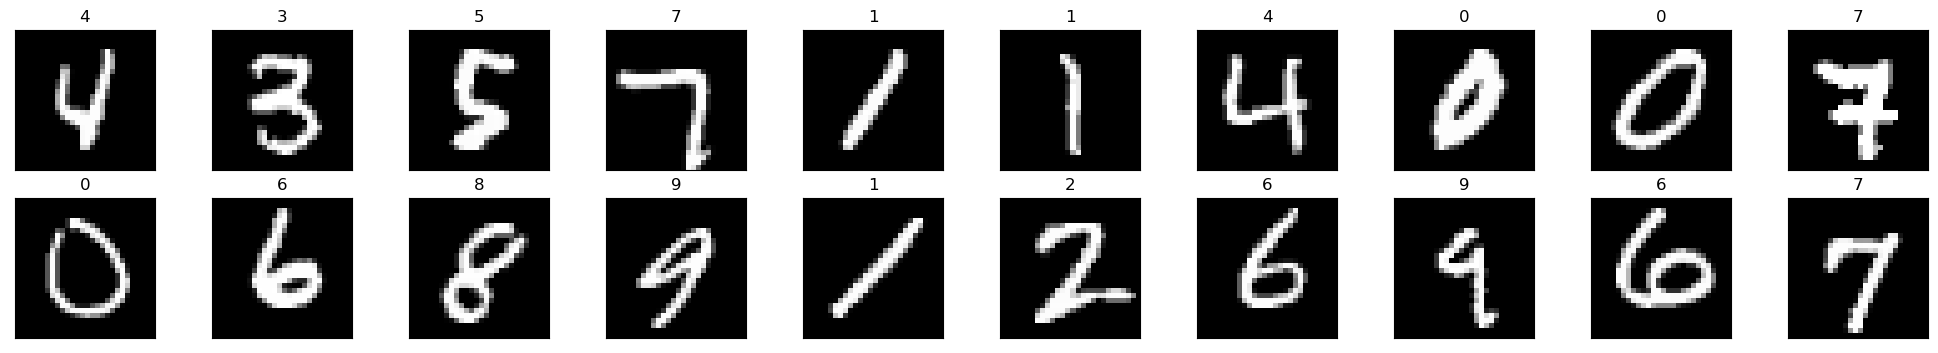

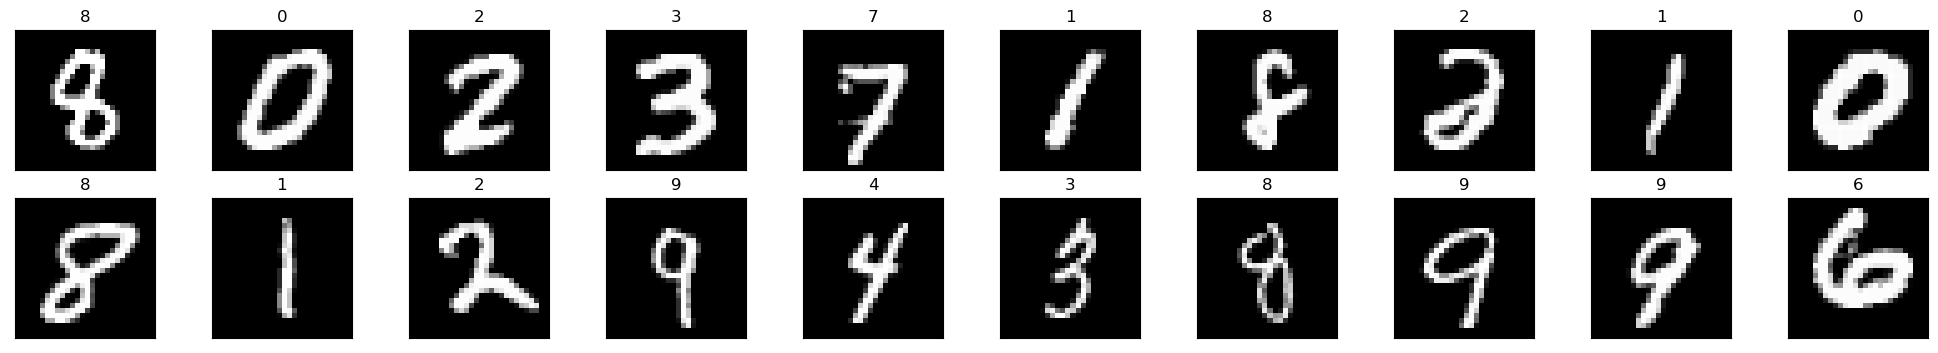

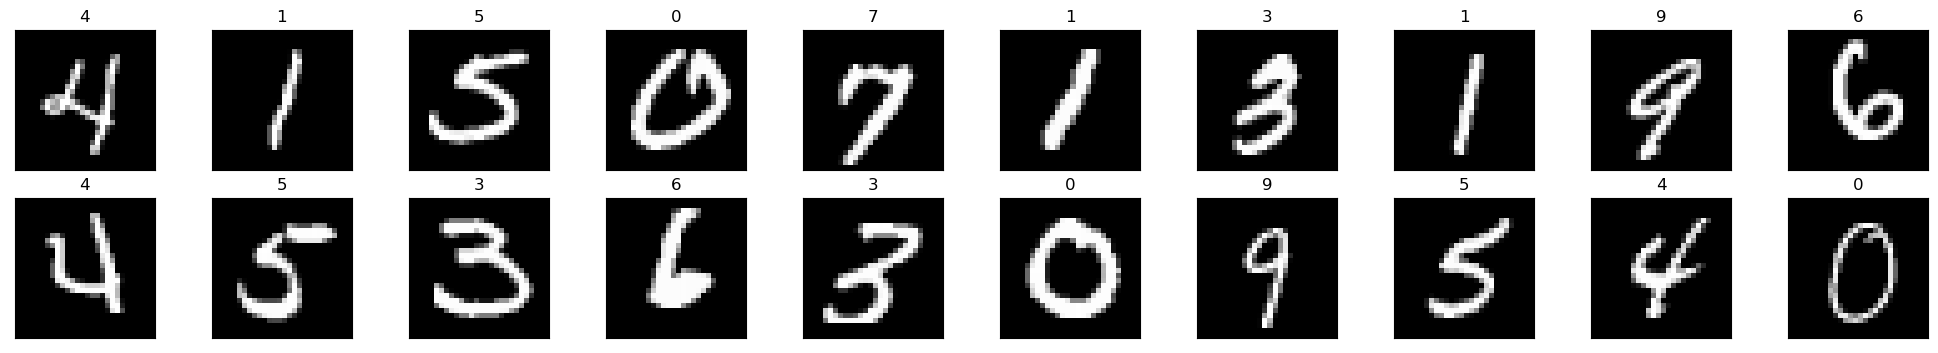

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
for i in range(3):
    images, labels = next(dataiter)
    images = images.numpy()
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(labels[idx].item()))

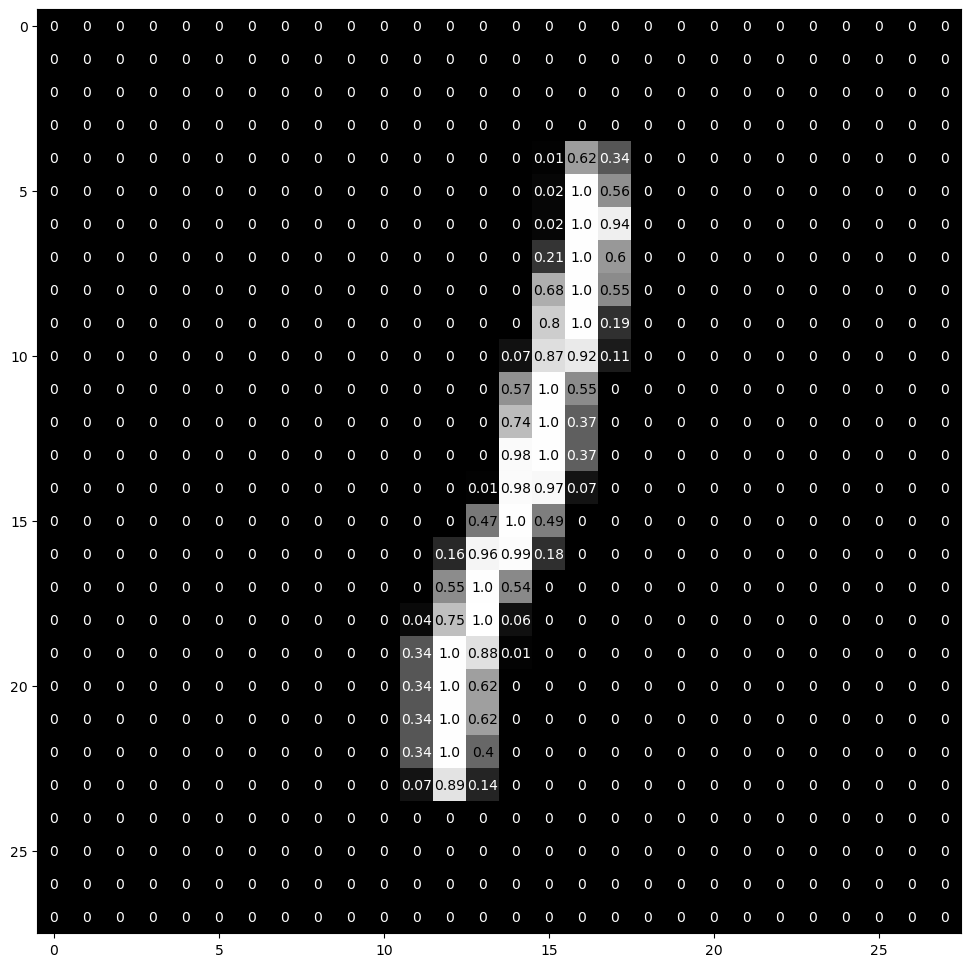

In [6]:
img = np.squeeze(images[1])
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [7]:
import torch.nn as nn
import torch.nn.functional as F
# define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # number of hidden nodes in each layer (512)
        self.n_hidden_1 = 512
        self.n_hidden_2 = 512
        self.n_hidden_3 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, self.n_hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(self.n_hidden_1, self.n_hidden_2)
        self.fc3 = nn.Linear(self.n_hidden_2, self.n_hidden_3)
        # linear layer (n_hidden -> 10)
        self.fc4 = nn.Linear(self.n_hidden_3, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)

    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
        # add hidden layers, with relu activation function
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc4(x)
        return x
# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [9]:
### Sends model to gpu

# mps_device = torch.device("mps")
# model.to(mps_device)

In [10]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()#.to(device)
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [11]:
# number of epochs to train the model
n_epochs = 50
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
     
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data,label in train_loader:


        # if torch.backends.mps.is_available():
        #     data, label = data.to(device), label.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)#.to(device)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
     ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for data,label in valid_loader:

        # if torch.backends.mps.is_available():
        #     data, label = data.to(device), label.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)#.to(device)
        # update running validation loss 
        valid_loss += loss.item() * data.size(0)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 1.267773 	Validation Loss: 0.423020
Validation loss decreased (inf --> 0.423020).  Saving model ...
Epoch: 2 	Training Loss: 0.372211 	Validation Loss: 0.294043
Validation loss decreased (0.423020 --> 0.294043).  Saving model ...
Epoch: 3 	Training Loss: 0.270000 	Validation Loss: 0.229375
Validation loss decreased (0.294043 --> 0.229375).  Saving model ...
Epoch: 4 	Training Loss: 0.207728 	Validation Loss: 0.180144
Validation loss decreased (0.229375 --> 0.180144).  Saving model ...
Epoch: 5 	Training Loss: 0.166965 	Validation Loss: 0.155737
Validation loss decreased (0.180144 --> 0.155737).  Saving model ...
Epoch: 6 	Training Loss: 0.140022 	Validation Loss: 0.137586
Validation loss decreased (0.155737 --> 0.137586).  Saving model ...
Epoch: 7 	Training Loss: 0.119766 	Validation Loss: 0.123612
Validation loss decreased (0.137586 --> 0.123612).  Saving model ...
Epoch: 8 	Training Loss: 0.103665 	Validation Loss: 0.113854
Validation loss decreased (0.12361

In [12]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in test_loader:

    if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.074133

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 98% (1012/1032)
Test Accuracy of     3: 97% (989/1010)
Test Accuracy of     4: 97% (962/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 98% (942/958)
Test Accuracy of     7: 97% (1005/1028)
Test Accuracy of     8: 97% (948/974)
Test Accuracy of     9: 98% (991/1009)

Test Accuracy (Overall): 98% (9816/10000)
